# Proyek Image Classification: [Intel-Image-Classification-dataset]
- **Nama:** [Tsamarah Muthi'ah Abdullah]
- **Email:** [a135xaf486@devacademy.id]
- **ID Dicoding:** [a135xaf48]

## **Import Library**

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import os
from sklearn.metrics import classification_report
from collections import defaultdict
import pandas as pd
from tensorflow.keras import Input
import numpy as np
import cv2

## **Dataset**

### **🗂️ Deskripsi Dataset**

Dataset yang digunakan yaitu ```Intel Image Classification``` yang berisi gambar pemandangan alam dan lingkungan yang terbagi ke dalam 6 kelas, yaitu:

- buildings (bangunan)
- forest (hutan)
- glacier (gletser)
- mountain (gunung)
- sea (laut)
- street (jalan)

Dataset ini memiliki total 20.034 gambar yang sudah terbagi secara terstruktur ke dalam 3 folder:

1. train/ (untuk pelatihan model)

2. test/ (untuk pengujian akhir)

3. val/ (untuk validasi selama pelatihan)

Setiap gambar beresolusi 150x150 piksel dan merepresentasikan kondisi nyata dengan berbagai variasi cahaya, sudut pandang, dan cuaca.

Pembagian dataset **Train : Validation : Test** = ```70 : 15 : 15```

- > **Link unduh dataset :** https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [3]:
# Path utama dataset
base_path = r"D:\PROJECT\LASKAR AI\Submission 6\intel-image-classification"

In [4]:
# Inisialisasi dictionary untuk menyimpan data
distribution = defaultdict(dict)

In [5]:
# Loop untuk tiap folder (train, test, val)
for dataset_type in ['train', 'test', 'val']:
    dataset_path = os.path.join(base_path, dataset_type)
    
    if os.path.exists(dataset_path):
        print(f"\n📁 {dataset_type.upper()} Folder")
        total_images = 0
        
        # Loop untuk tiap kelas di dalam folder
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            
            if os.path.isdir(class_path):
                count = len([
                    fname for fname in os.listdir(class_path)
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
                ])
                distribution[dataset_type][class_name] = count
                total_images += count
                print(f"  - {class_name:10s}: {count} gambar")
        
        print(f"  👉 Total gambar di {dataset_type}: {total_images}")


📁 TRAIN Folder
  - buildings : 2191 gambar
  - forest    : 2271 gambar
  - glacier   : 2404 gambar
  - mountain  : 2512 gambar
  - sea       : 2274 gambar
  - street    : 2382 gambar
  👉 Total gambar di train: 14034

📁 TEST Folder
  - buildings : 437 gambar
  - forest    : 474 gambar
  - glacier   : 553 gambar
  - mountain  : 525 gambar
  - sea       : 510 gambar
  - street    : 501 gambar
  👉 Total gambar di test: 3000

📁 VAL Folder
  - buildings : 437 gambar
  - forest    : 474 gambar
  - glacier   : 553 gambar
  - mountain  : 525 gambar
  - sea       : 510 gambar
  - street    : 501 gambar
  👉 Total gambar di val: 3000


In [6]:
# Print semua hasil distribusi dalam bentuk tabel
print("\n📊 Distribusi Lengkap dalam Tabel:")
df = pd.DataFrame(distribution).fillna(0).astype(int)
display(df)


📊 Distribusi Lengkap dalam Tabel:


,train,test,val
buildings,2191,437,437
forest,2271,474,474
glacier,2404,553,553
mountain,2512,525,525
sea,2274,510,510
street,2382,501,501


## **Preprocessing**

In [7]:
# Menyusun path ke masing-masing folder
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

In [7]:
# Parameter preprocessing
img_size = (150, 150)
batch_size = 32

🖼️ Menentukan ukuran gambar yang akan diubah menjadi ```(150x150 piksel)```

📦 Serta jumlah gambar yang diproses per batch selama training ```(32 gambar sekaligus).```

In [9]:
# Membuat generator dengan rescaling (normalisasi pixel)
# Data Augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi pixel gambar dari 0-255 menjadi 0-1 agar model lebih cepat dan stabil belajar.
    
    rotation_range=20,           # Augmentasi: Memutar gambar secara acak dalam rentang -20 hingga +20 derajat.
    
    width_shift_range=0.1,       # Augmentasi: Menggeser gambar secara horizontal (lebar) sebanyak 10% dari total lebar gambar.
    
    height_shift_range=0.1,      # Augmentasi: Menggeser gambar secara vertikal (tinggi) sebanyak 10% dari total tinggi gambar.
    
    zoom_range=0.2,              # Augmentasi: Melakukan zoom in/out secara acak hingga 10%.

    fill_mode='nearest',

    shear_range=0.1,
    
    horizontal_flip=True         # Augmentasi: Membalik gambar secara horizontal.
)


val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

- Melakukan augmentasi data pada data training
- ```rescale=1./255``` digunakan untuk menormalkan pixel dari 0–255 menjadi 0–1.

In [10]:
# Membaca gambar dan mempersiapkan data untuk model
train_data = train_gen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**📚 Membaca data train, val, dan test dari folder:**

- Mengubah ukuran jadi 150x150

- Membagi menjadi batch

- Label dikonversi ke bentuk one-hot encoding ```(class_mode='categorical')```

- Fungsi ```shuffle``` digunakan untuk mengacak urutan data setiap epoch saat training

## **Model Building**

In [16]:
# Model CNN
model = Sequential([
    # Layer 1: Conv + MaxPool
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer 2: Conv + MaxPool
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Layer 3: Conv + MaxPool
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Layer 4: Conv + MaxPool
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Flatten dan Dense
    Flatten(),                       # Mengubah hasil Conv2D jadi 1D
    Dense(512, activation='relu'),   # Hidden layer dengan 512 neuron
    Dropout(0.5),                    # Mencegah overfitting (drop 50% neuron saat training)
    Dense(6, activation='softmax')   # Output layer untuk 6 kelas (multi-class classification)
])

In [18]:
# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Callback
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [20]:
# Training
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/30
439/439 [==============================] - 169s 382ms/step - loss: 1.9590 - accuracy: 0.5493 - val_loss: 1.6393 - val_accuracy: 0.5920 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 191s 434ms/step - loss: 0.9508 - accuracy: 0.6627 - val_loss: 1.3929 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 197s 448ms/step - loss: 0.8759 - accuracy: 0.6916 - val_loss: 0.6295 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 205s 467ms/step - loss: 0.8041 - accuracy: 0.7164 - val_loss: 0.9054 - val_accuracy: 0.6723 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 190s 432ms/step - loss: 0.7372 - accuracy: 0.7400 - val_loss: 0.6820 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.7590  
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
439/439 [=====================

- **Akurasi training terakhir: 88.23%**

- **Akurasi validasi terakhir: 88.73%**

- **Loss validasi terbaik: Sekitar 0.35-an**

- **Perbedaan akurasi training dan validasi: Sangat kecil di akhir → tidak terlihat overfitting signifikan di akhir training.**

- **Learning rate berhasil diturunkan secara bertahap berkat ReduceLROnPlateau, yang membantu menghindari overfitting lebih dalam dan memperhalus pembelajaran.**

- **Model menyimpan bobot terbaik di epoch ke-25 berdasarkan val_loss.**

## **Evaluasi**

In [21]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

94/94 [==============================] - 8s 83ms/step - loss: 0.3529 - accuracy: 0.8893
Test accuracy: 0.89


In [22]:
# Prediksi label dari test set
y_pred_probs = model.predict(test_data) # output prediksi probabilitas dari model.
y_pred = np.argmax(y_pred_probs, axis=1) # mengubah probabilitas ke label kelas (nilai integer).

94/94 [==============================] - 8s 83ms/step


In [23]:
# Label sebenarnya dari test set
y_true = test_data.classes

In [24]:
# Nama kelas
class_labels = list(test_data.class_indices.keys())

In [25]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels)) # menampilkan precision, recall, f1-score per kelas.


Classification Report:
              precision    recall  f1-score   support

   buildings       0.84      0.90      0.87       437
      forest       0.96      0.98      0.97       474
     glacier       0.86      0.85      0.86       553
    mountain       0.87      0.82      0.85       525
         sea       0.89      0.91      0.90       510
      street       0.91      0.89      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



**📊 Hasil Classification Report:**
- Akurasi total: 89%
- Kinerja per kelas:
1. Forest: performa terbaik (Precision: 96%, Recall: 98%)
2. Buildings & Sea: cukup baik (F1-score sekitar 87–90%)
3. Mountain & Glacier: performa lebih rendah (F1-score ~85–86%)
4. Macro Avg F1-score: 89% (rata-rata antar kelas)
5. Weighted Avg F1-score: 89% (mempertimbangkan jumlah data per kelas)

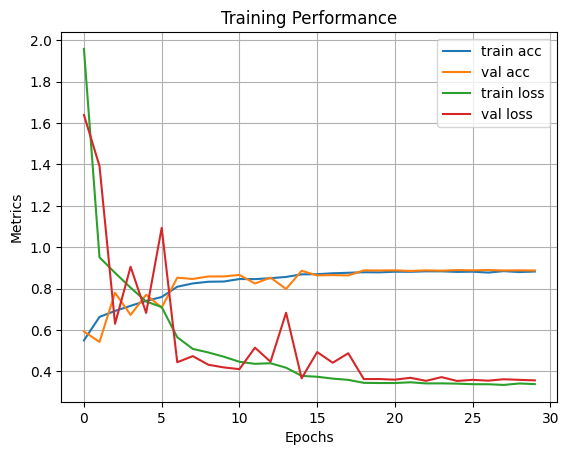

In [26]:
# Visualisasi akurasi dan loss
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.grid(True)
plt.title("Training Performance")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

**📊 Analisis Grafik**

1. ✅Train Accuracy vs Validation Accuracy (garis biru dan oranye)

- Awal training (epoch 0–5): Terjadi peningkatan yang cepat di kedua metrik, meskipun sempat fluktuatif.
- Setelah epoch 5: Akurasi stabil dan mendekati satu sama lain, berada di sekitar 88%.
- Tidak terlihat overfitting berarti, karena tidak ada divergensi besar antara dua garis ini.

2. ❎Train Loss vs Validation Loss (garis hijau dan merah)

- Epoch 0–5: Fluktuasi cukup besar, terutama di validation loss (kemungkinan model masih menyesuaikan learning rate).
- Setelah epoch 6: Loss pada kedua kurva menurun konsisten dan stabil.
- Validation loss mengalami fluktuasi kecil, tapi tetap berada pada tren menurun dan akhirnya stabil di bawah 0.5.

## **Save Model**

In [27]:
# Saved_Model
# Simpan model ke format .keras atau .h5 
model.save('cnn_model.h5')  # atau 'modelku.h5'

# Simpan model ke format SavedModel (.pb)
tf.saved_model.save(model, 'saved_model_format/')

C:\Users\ACER NITRO V15\anaconda3\envs\image-classification\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model_format/assets


INFO:tensorflow:Assets written to: saved_model_format/assets


In [28]:
# TF-Lite
# Load model dari .keras atau .h5
model = tf.keras.models.load_model('cnn_model.h5')  # atau 'modelku.h5'

# Converter ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open('cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ACERNI~1\AppData\Local\Temp\tmprts145im\assets


INFO:tensorflow:Assets written to: C:\Users\ACERNI~1\AppData\Local\Temp\tmprts145im\assets


In [ ]:
# TF-Js
# Load model dari file .h5
import tensorflowjs as tfjs
from tensorflow import keras
model = keras.models.load_model('cnn_model.h5')

# Konversi ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model/')

In [ ]:
# Simpan label.txt berdasarkan urutan class_indices
with open('C:/Users/ACER NITRO V15/label.txt', 'w') as f:
    for label in sorted(train_data.class_indices, key=lambda x: train_data.class_indices[x]):
        f.write(f"{label}\n")

## **Inference**

In [13]:
# Inisialisasi interpreter untuk model TFLite
interpreter = tf.lite.Interpreter(model_path="cnn_model.tflite")

# Alokasikan memori untuk tensor (wajib dilakukan sebelum inferensi)
interpreter.allocate_tensors()

# Ambil detail tensor input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load gambar yang ingin diuji
img = cv2.imread(r'D:\PROJECT\LASKAR AI\Submission 6\intel-image-classification\inference\143.jpg')
img = cv2.resize(img, (150, 150))  # Ukuran disesuaikan dengan input model
img = np.expand_dims(img / 255.0, axis=0).astype(np.float32)  # Normalisasi dan reshape

# Masukkan gambar ke dalam tensor input model menggunakan index
interpreter.set_tensor(input_details[0]['index'], img)

# Jalankan inferensi
interpreter.invoke()

# Ambil hasil output dari tensor menggunakan index
output_data = interpreter.get_tensor(output_details[0]['index'])
labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
print("Predicted class:", labels[np.argmax(output_data)])

# Tampilkan hasil prediksi
print("Predicted class:", np.argmax(output_data))

Predicted class: mountain
Predicted class: 3
